# Chapter 9 Practice Answers

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from watermark import watermark

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-07-04T20:30:06.921139-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

pymc      : 5.9.2
numpy     : 1.25.2
matplotlib: 3.8.2
pandas    : 2.1.3
arviz     : 0.16.1



# 9E1 Question
Which of the following is a requirement of the simple Metropolis algorithm?
1. The parameters must be discrete.
2. The likelihood function must be Gaussian.
3. The proposal distribution must be symmetric.

3 is required - the proposal distribution must be symmetric

# 9E2 Question
Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra
efficiency? Are there any limitations to the Gibbs sampling strategy?

 Gibbs sample is more efficient than Metropolis because it uses better sampling methods (e.g. conjugate priors), so it needs fewer samples to get a good idea of the distribution.  However, both Metropolis and Gibbs sampling struggle with high dimentions, highly correlated parameter, and Gibbs sampling can have issues when there is not a conjugate prior/analytics solution to the posterior. 

# 9E3 Question
Which sort of parameters can Hamiltonian Monte Carlo not handle? Can you explain why?


HMC requires continuous paramters.  So if you are using discrete paramaters, some changes in coding are required.

# 9E4 Question
Explain the difference between the effective number of samples, n_eff as calculated by Stan,
and the actual number of samples.

The number of samples is the number of draws from the posterior.  The posterior sames are autocorrelated, so the number of uncorrelated samples is the number of effective samples.  Typically the number of effective samples will be lower or the same as the number of samples.  However,  Since Stan and HMC can be efficient, sometimes the effective number of samples is higher than the samples 

# 9E5 Question 
Which value should Rhat approach, when a chain is sampling the posterior distribution correctly

It should approach one.  Bad chains have rhat > 1

# 9E6 Question 
Sketch a good trace plot for a Markov chain, one that is effectively sampling from the posterior
distribution. What is good about its shape? Then sketch a trace plot for a malfunctioning Markov
chain. What about its shape indicates malfunction?
# 9E7 Question
Repeat the problem above, but now for a trace rank plot

Answers to 9E6/9E7: Diagrams were drawn by hand in a notebook

# 9M1 Question
Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior for the standard deviation, sigma. The uniform prior should be dunif(0,1). Use ulam to estimate the posterior. Does the different prior have any detectible influence on the posterior distribution of sigma? Why or why not? 

In [6]:
#9M1
rugged_data_raw = pd.read_csv('./data/rugged.csv', sep=';')

rugged_data_raw["log_gdp"] = np.log(rugged_data_raw["rgdppc_2000"])

rugged_data = rugged_data_raw.dropna(subset=["log_gdp"])
rugged_data["log_gdp_std"] = rugged_data["log_gdp"] / rugged_data["log_gdp"].mean()
rugged_data["rugged_std"] = rugged_data["rugged"] / rugged_data["rugged"].max()

C:\Users\ukamath\AppData\Local\Temp\ipykernel_23648\1358475823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rugged_data["log_gdp_std"] = rugged_data["log_gdp"] / rugged_data["log_gdp"].mean()
C:\Users\ukamath\AppData\Local\Temp\ipykernel_23648\1358475823.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rugged_data["rugged_std"] = rugged_data["rugged"] / rugged_data["rugged"].max()


In [7]:
cid = pd.Categorical(rugged_data["cont_africa"])

with pm.Model() as m_9m1_a:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m1_a_trace = pm.sample(chains=4,return_inferencedata=True)

with pm.Model() as m_9m1_b:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Uniform('sigma',0,1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m1_b_trace = pm.sample(chains=4,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


<Axes: title={'center': 'sigma'}>

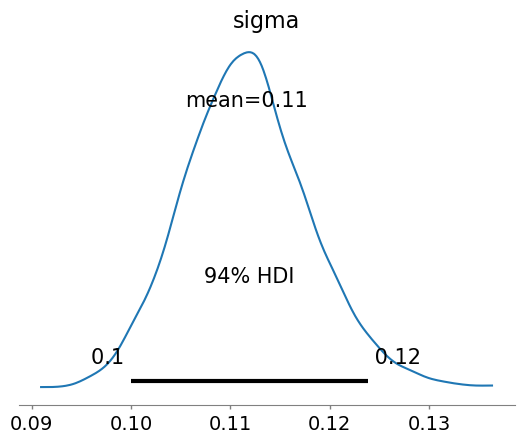

In [8]:
az.plot_posterior(m_9m1_a_trace,var_names='sigma')

<Axes: title={'center': 'sigma'}>

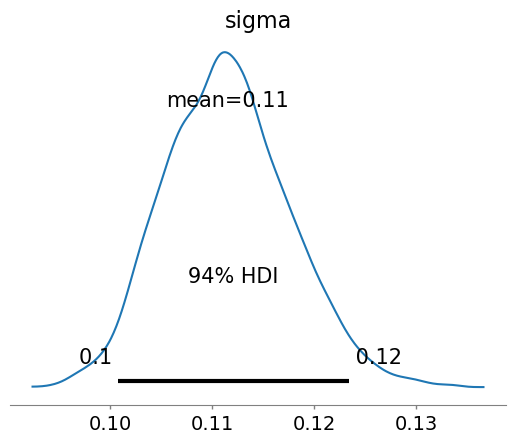

In [9]:
az.plot_posterior(m_9m1_b_trace,var_names='sigma')

The parameter estimates look fairly identical

# 9M2 Question
Modify the terrain ruggedness model again. This time, change the prior for b[cid] to dexp(0.3).
What does this do to the posterior distribution? Can you explain it

In [10]:
#9M2
with pm.Model() as m_9m2:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Exponential("b", 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

    m_9m2_trace = pm.sample(chains=4,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [11]:
az.summary(m_9m2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.049,0.011,1.028,1.067,0.000,0.000,3418.0,2811.0,1.0
a[1],0.885,0.016,0.855,0.916,0.000,0.000,3402.0,2583.0,1.0
b[0],0.018,0.018,0.000,0.050,0.000,0.000,2590.0,1547.0,1.0
b[1],0.143,0.073,0.010,0.272,0.001,0.001,2241.0,1193.0,1.0
sigma,0.114,0.006,0.102,0.126,0.000,0.000,3257.0,2444.0,1.0


array([<Axes: title={'center': 'b\n0'}>, <Axes: title={'center': 'b\n1'}>],
      dtype=object)

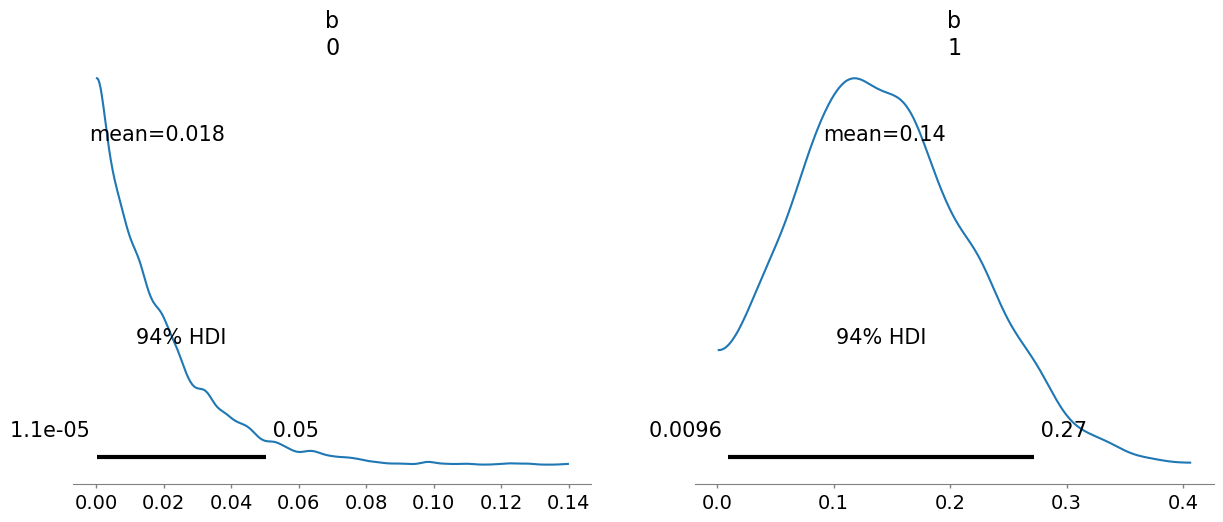

In [12]:
az.plot_posterior(m_9m2_trace,var_names='b')

array([<Axes: title={'center': 'b\n0'}>, <Axes: title={'center': 'b\n1'}>],
      dtype=object)

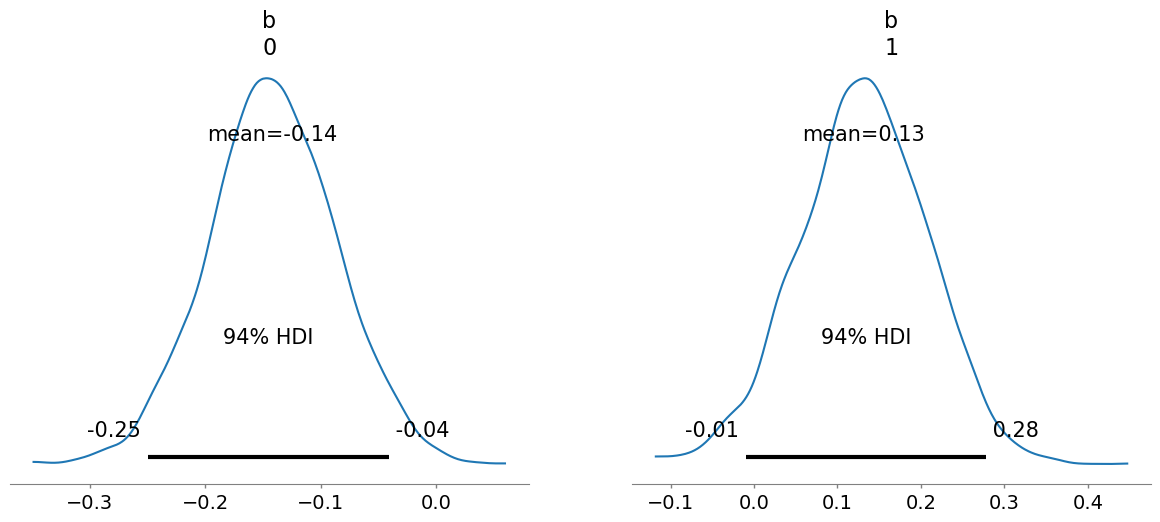

In [13]:
az.plot_posterior(m_9m1_a_trace,var_names='b')

The exponential distribution basically forces all values to be above zero.  But if we look at the original model, almost the entire distribution of b0 is below zero.  So you can see the effect where b0 is changed a lot and the distribution is forced to 0.  But for b1, the left side of the distribution cuts off at zero, but is still closer to the b0 of the original model.

#9M3. 
Re-estimate one of the Stan models from the chapter, but at different numbers of warmup iterations. Be sure to use the same number of sampling iterations in each case. Compare the n_eff
values. How much warmup is enough?

In [14]:
warmup_steps = [50,100,150,200,300,400,500,1000,1500]
m_9m3_traces = {}


with pm.Model() as m_9m3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)
    mu = a[np.array(cid)] + b[np.array(cid)] * (rugged_data["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=rugged_data["log_gdp_std"].values)

with m_9m3:
    for step in warmup_steps: 
        m_9m3_trace = pm.sample(chains=4,return_inferencedata=True, tune = step)
        m_9m3_traces[step] = m_9m3_trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 150 tune and 1_000 draw iterations (600 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 400 tune and 1_000 draw iterations (1_600 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 16 seconds.


In [16]:
for value, step in enumerate(m_9m3_traces):
    if value == 0:
        m_9m3_steps_bulk = pd.DataFrame(az.summary(m_9m3_traces[step])['ess_bulk']).rename(columns={'ess_bulk':step})
    else:
        m_9m3_steps_bulk = m_9m3_steps_bulk.join(pd.DataFrame(az.summary(m_9m3_traces[step])['ess_bulk']).rename(columns={'ess_bulk':step}))
m_9m3_steps_bulk

,50,100,150,200,300,400,500,1000,1500
a[0],4935.0,4565.0,3734.0,4567.0,4637.0,5200.0,5346.0,4596.0,6527.0
a[1],4274.0,4370.0,3475.0,5566.0,4075.0,3552.0,4876.0,6470.0,5838.0
b[0],2411.0,2301.0,2763.0,5427.0,4703.0,4926.0,5797.0,6576.0,6571.0
b[1],1660.0,1450.0,3410.0,4895.0,4296.0,4511.0,5486.0,6751.0,6855.0
sigma,2512.0,2407.0,3052.0,5242.0,4261.0,5234.0,5999.0,6259.0,5668.0


In [17]:
for value, step in enumerate(m_9m3_traces):
    if value == 0:
        m_9m3_steps_tail = pd.DataFrame(az.summary(m_9m3_traces[step])['ess_tail']).rename(columns={'ess_tail':step})
    else:
        m_9m3_steps_tail = m_9m3_steps_tail.join(pd.DataFrame(az.summary(m_9m3_traces[step])['ess_tail']).rename(columns={'ess_tail':step}))
m_9m3_steps_tail

,50,100,150,200,300,400,500,1000,1500
a[0],3186.0,2742.0,2898.0,2905.0,3378.0,3186.0,3049.0,3061.0,3365.0
a[1],3187.0,3142.0,2833.0,2959.0,3310.0,3337.0,2924.0,3725.0,2891.0
b[0],2242.0,1870.0,2718.0,2811.0,3377.0,3272.0,3448.0,3016.0,3269.0
b[1],1662.0,1596.0,2880.0,2916.0,3009.0,2790.0,3424.0,3729.0,3950.0
sigma,2193.0,2184.0,2974.0,2552.0,3359.0,3085.0,2957.0,3260.0,3366.0


Text(0.5, 1.0, 'Tail Samples')

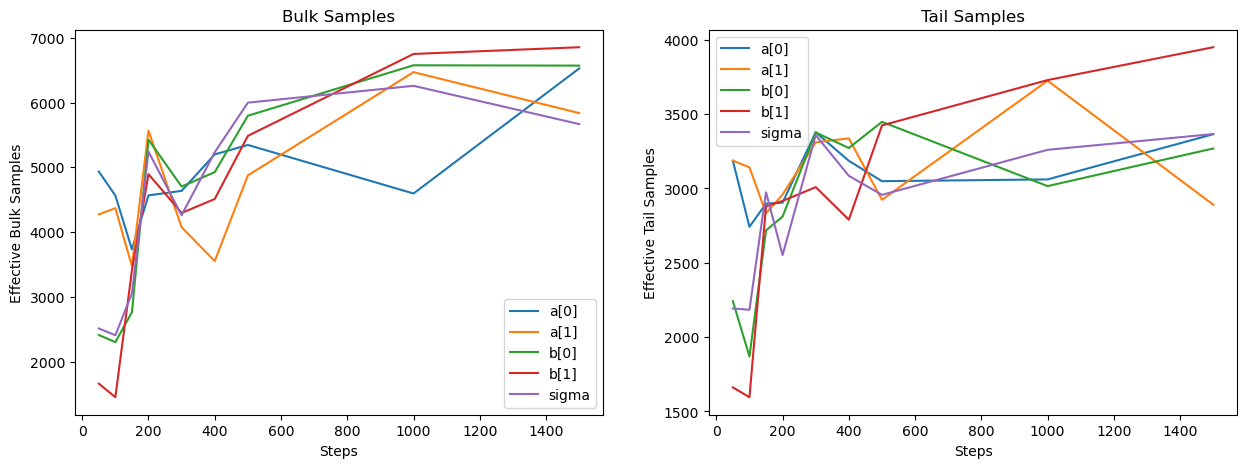

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
m_9m3_steps_bulk.T.plot(ax = ax[0])
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Effective Bulk Samples')
ax[0].set_title('Bulk Samples')

m_9m3_steps_tail.T.plot(ax = ax[1])
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Effective Tail Samples')
ax[1].set_title('Tail Samples')

For the most part, it looks like the effective number of samples starts stabilizing fairly quickly, by 600 steps or so.  

# 9H1 Question
Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

R code\
9.28 mp <- ulam(\
alist(\
a ~ dnorm(0,1),\
b ~ dcauchy(0,1)\
), data=list(y=1) , chains=1 )

Compare the samples for the parameters a and b. Can you explain the different trace plots? If you are
unfamiliar with the Cauchy distribution, you should look it up. The key feature to attend to is that it
has no expected value. Can you connect this fact to the trace plot?


In [19]:
with pm.Model() as m_9h1:
    a = pm.Normal("a", 0, 1)
    b = pm.Cauchy("b", 0, 1)
    #y = 1
    m_9h1_trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

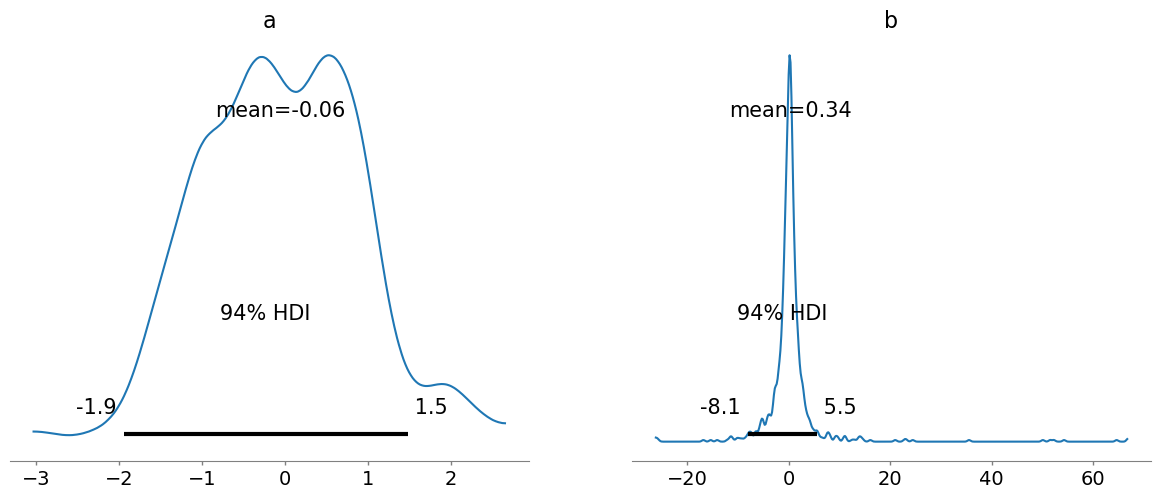

In [20]:
az.plot_posterior(m_9h1_trace)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

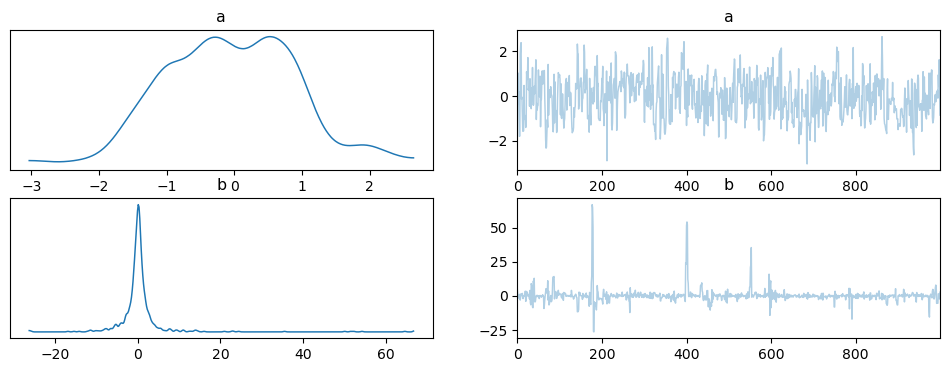

In [21]:
az.plot_trace(m_9h1_trace)

Given that the cauchy distribution seems to basically be a spike at a certain value and low density everwhere else, one would assume the trace will not wander around a lot because the majority of samples are going to be very close to each other, with some extreme values if it samples from the tails

# 9H2 Question

Recall the divorce rate example from Chapter 5. Repeat that analysis, using ulam this time,
fitting models m5.1, m5.2, and m5.3. Use compare to compare the models on the basis of WAIC
or PSIS. To use WAIC or PSIS with ulam, you need add the argument log_log=TRUE. Explain the
model comparison results

In [24]:
divorce_data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")  # load waffle data

In [25]:
# scale all of the data
divorce_data['marriage_std'] = (divorce_data['Marriage'] - np.mean(divorce_data['Marriage'])) / np.std(divorce_data['Marriage'])
divorce_data['age_std'] = (divorce_data['MedianAgeMarriage'] - np.mean(divorce_data['MedianAgeMarriage'])) / np.std(divorce_data['MedianAgeMarriage'])
divorce_data['divorce_std'] = (divorce_data['Divorce'] - np.mean(divorce_data['Divorce'])) / np.std(divorce_data['Divorce'])

In [26]:
# running a Age_divorce linear regression
with pm.Model() as m_9h2_a:
    alpha = pm.Normal("alpha", 0, 0.2)  
    beta = pm.Normal("beta_A", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)  
    mu = alpha + beta * divorce_data['age_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std'])  
    m_9h2_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})


with pm.Model() as m_9h2_b:
    alpha = pm.Normal("alpha", 0, 0.2)  
    beta = pm.Normal("beta_M", 0, 0.2)  
    sigma = pm.Exponential("sigma", 1)  
    mu = alpha + beta * divorce_data['marriage_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std']) 
    m_9h2_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})


with pm.Model() as m_9h2_c:
    alpha = pm.Normal("alpha", 0, 0.2)  
    beta = pm.Normal("beta_M", 0, 0.5, shape=2)  
    sigma = pm.Exponential("sigma", 1)  
    mu = alpha + beta[0] * divorce_data['age_std'] + beta[1] * divorce_data['marriage_std']
    Divorce = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=divorce_data['divorce_std'])  
    m_9h2_c_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [27]:
compare_9h2 = {"Age": m_9h2_a_trace, "Marriage": m_9h2_b_trace, "Age and Marraige": m_9h2_c_trace}
az.compare(compare_9h2, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, plea

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Age,0,127.102539,3.804448,0.000000,0.890717,12.812322,0.000000,False,deviance
Age and Marraige,1,128.835397,4.873189,1.732858,0.000000,12.857615,0.674651,True,deviance
Marriage,2,140.317253,2.491230,13.214714,0.109283,9.185004,9.828172,False,deviance


It looks like the model without Age as a predictor is clearly worse than the other two with Age.  Note that in the textbook, I think this assumes this is the first time we are using HMC.  However, since we are using PyMC and not the textbook functions (e.g. ulam), we have always been using HMC.  So this howework exercise proably doesn't have the learning effect it was orignally meant to.

#9H3. 

Sometimes changing a prior for one parameter has unanticipated effects on other parameters.
This is because when a parameter is highly correlated with another parameter in the posterior, the
prior influences both parameters. Here’s an example to work and think through.
Go back to the leg length example in Chapter 6 and use the code there to simulate height and
leg lengths for 100 imagined individuals. Below is the model you fit before, resulting in a highly
correlated posterior for the two beta parameters. This time, fit the model using ulam:

R code\
m5.8s <- ulam(\
alist(\
height ~ dnorm( mu , sigma ) ,\
mu <- a + bl*leg_left + br*leg_right ,\
a ~ dnorm( 10 , 100 ) ,\
bl ~ dnorm( 2 , 10 ) ,\
br ~ dnorm( 2 , 10 ) ,\
sigma ~ dexp( 1 )\
) , data=d, chains=4,\
start=list(a=10,bl=0,br=0.1,sigma=1) )

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for br so that it is strictly positive:

m5.8s2 <- ulam(\
alist(\
height ~ dnorm( mu , sigma ) ,\
mu <- a + bl*leg_left + br*leg_right ,\
a ~ dnorm( 10 , 100 ) ,\
bl ~ dnorm( 2 , 10 ) ,\
br ~ dnorm( 2 , 10 ) ,\
sigma ~ dexp( 1 )\
) , data=d, chains=4,\
constraints=list(br="lower=0"),\
start=list(a=10,bl=0,br=0.1,sigma=1) )

Note the constraints list. What this does is constrain the prior distribution of br so that it has
positive probability only above zero. In other words, that prior ensures that the posterior distribution
for br will have no probability mass below zero. Compare the two posterior distributions for m5.8s
and m5.8s2. What has changed in the posterior distribution of both beta parameters? Can you
explain the change induced by the change in prior

In [2]:
N = 100  
height_data = np.random.normal(10, 2, N)  
leg_prop = np.random.uniform(0.4, 0.5, N) 
left_leg = leg_prop * height_data + np.random.normal(0, 0.02, N) 
right_leg = leg_prop * height_data + np.random.normal(0, 0.02, N) 


with pm.Model() as m_9h3_a:
    alpha = pm.Normal("alpha", 10, 100) 
    bl = pm.Normal("bl", 2, 10)  
    br = pm.Normal("br", 2, 10)  
    sigma = pm.Exponential("sigma", 1)  
    mu = alpha + bl*left_leg + br*right_leg
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=height_data) 
    m_9h3_a_trace = pm.sample(chains = 4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.


In [ ]:
with pm.Model() as m_9h3_b:
    alpha = pm.Normal("alpha", 10, 100)  
    bl = pm.Normal("bl", 2, 10)
    br = pm.TruncatedNormal('br', mu=2, sigma=10, lower=0)
    sigma = pm.Exponential("sigma", 1) 
    mu = alpha + bl*left_leg + br*right_leg
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=height_data) 
    m_9h3_b_trace = pm.sample(chains = 4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 741 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'bl'}>,
       <Axes: title={'center': 'br'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

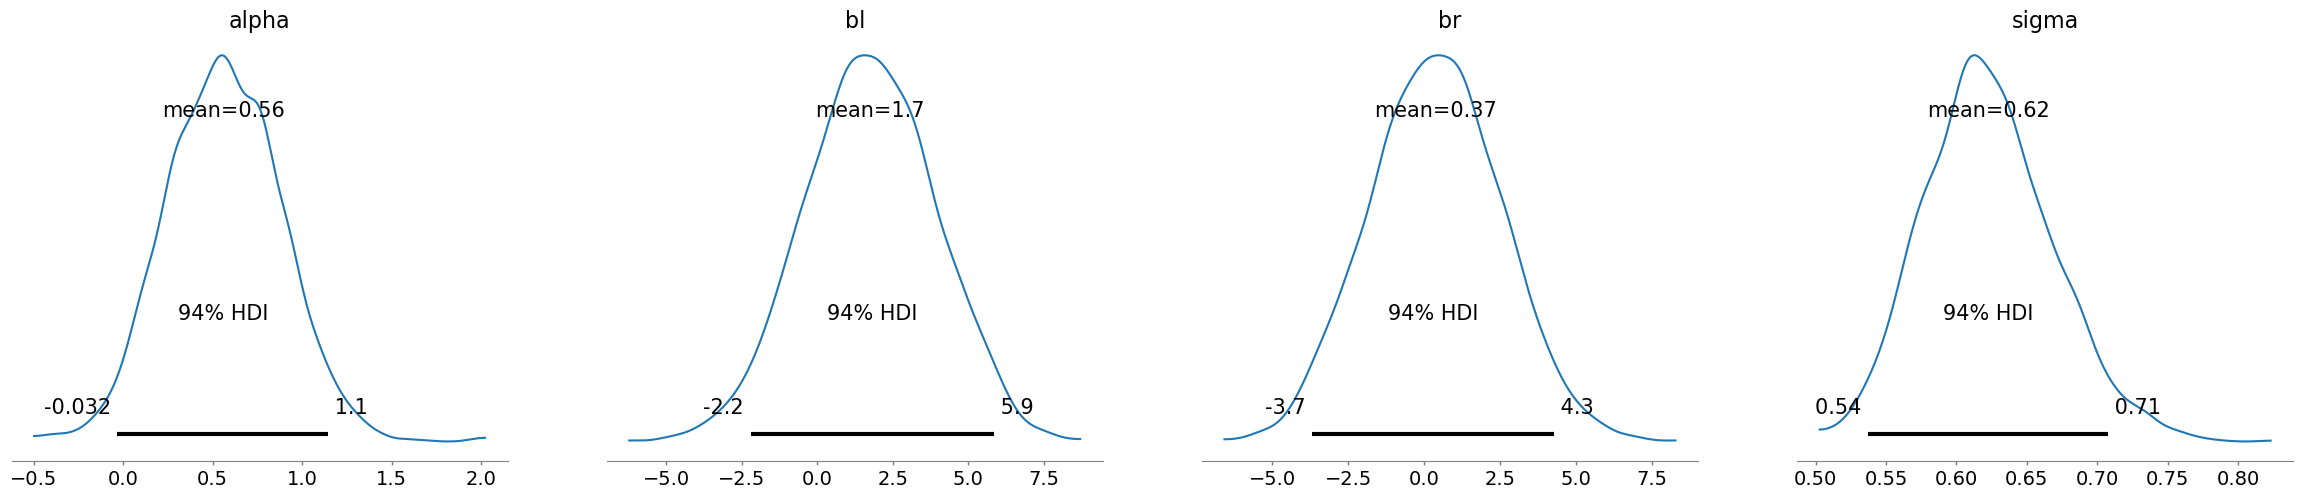

In [ ]:
az.plot_posterior(m_9h3_a_trace)

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'bl'}>,
       <Axes: title={'center': 'br'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

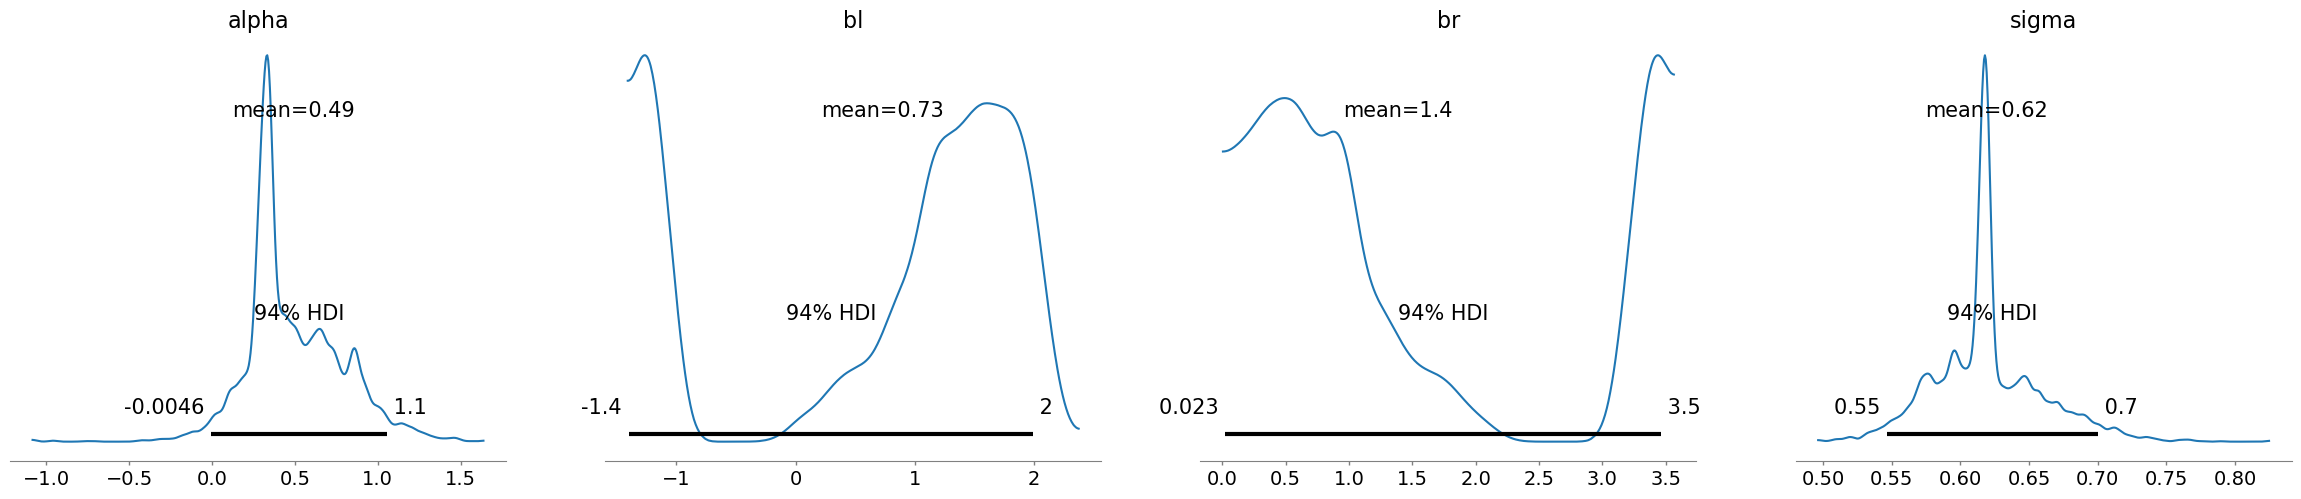

In [ ]:
az.plot_posterior(m_9h3_b_trace)

For the model with the constrained br, it looks like bl and br are generally mirroring each other.  So basically, in order to maintain the relationship between bl and br (which are both identially correlated with height), bl has changed to match the change in br.